# Anomaly detection algorithms

We are particularly interested in detecting anomalies in continuous time series data i.e. data coming from:
1. IOT / Edge devices
2. Sensors 

Even though data used for this demo has labels, we solve this as an unsupervised learning problem since that will be accurate reflection of most real scenarios 

Data is taken from this wonderful blog post explaining LSTM autoencoders for anomaly detection : https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb


In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyod

In [2]:
#read in data#
df=pd.read_csv('rawdata.csv')
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [3]:
df.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
count,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,...,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000
mean,0.006740,0.011824,0.157986,0.569300,-9.958345,0.006518,2.387533,0.001647,-0.004125,-0.003056,...,0.380519,0.360246,0.173708,2.379154,9.234953,0.233493,-0.001861,-0.061522,0.001258,0.001033
std,0.081822,0.742875,4.939762,5.937178,131.033712,0.634054,37.104012,0.108870,0.075460,0.156047,...,6.211598,14.174273,3.029516,67.940694,81.274103,2.326838,0.048732,10.394085,0.004721,0.032120
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-187.943440,-1817.595500,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.012229,0.000000
25%,0.000000,-0.405681,-2.158235,-3.537054,-111.378372,-0.446787,-24.345268,-0.058520,-0.051043,-0.059966,...,-3.672684,-1.928166,0.487780,-40.050046,-45.519149,-1.598804,0.000470,0.295023,-0.001805,0.000000
50%,0.000000,0.128245,-0.075505,-0.190683,-14.881585,-0.120745,10.528435,-0.009339,-0.000993,-0.030057,...,0.294846,0.143612,0.702299,17.471317,1.438806,0.085826,0.012888,0.734591,0.000710,0.000000
75%,0.000000,0.421222,2.319297,3.421223,92.199134,0.325152,32.172974,0.060515,0.038986,0.001990,...,5.109543,3.230770,2.675751,44.093387,63.209681,2.222118,0.020991,1.266506,0.004087,0.000000
max,1.000000,3.054156,16.742105,15.900116,334.694098,4.239385,96.060768,1.705590,0.788826,4.060033,...,14.180588,11.148006,6.637265,287.252017,252.147455,6.922008,0.067249,6.985460,0.020510,1.000000


In [4]:
## lets check anomaly class distribution ##
df.y.value_counts()

0    18274
1      124
Name: y, dtype: int64

In [5]:
## seperate df into x and y dfs ##
#dropping label, time and categorical columns : this is from blogpost referred above 
x_df=df.drop(['y','x28','x61','time'],axis=1)
y_df=df['y']

## train test split ##

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_df,y_df,test_size=0.20,random_state=42)

In [6]:
## scale features using standard scaler ##
from sklearn.preprocessing import StandardScaler
slr=StandardScaler()
slr.fit(x_train)
x_train=slr.transform(x_train)
x_test=slr.transform(x_test)

In [7]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=100)


In [8]:
tsne_x=tsne.fit_transform(x_train)

In [9]:
## lets visualize outliers using tsne #
visual_df=pd.DataFrame()
visual_df=pd.concat([pd.DataFrame(tsne_x),y_train],axis=1,ignore_index=True)
#visual_df=visual_df.fillna(0)

In [10]:
visual_df.columns=['c1','c2','y']

In [11]:
type(tsne_x)

numpy.ndarray

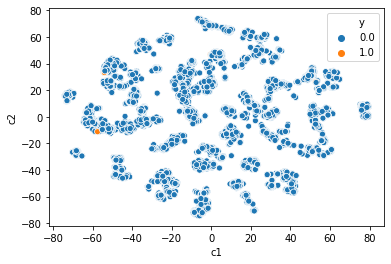

In [12]:
plt.close()
sns.scatterplot(visual_df['c1'],visual_df['c2'],hue=visual_df['y'])
plt.show()

# Anomaly detection algorithms from PyOD

This code is mostly taken from this tutorial post https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/


In [13]:
from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.006
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [22]:
algos=[]
fscores=[]
prcis=[]
recls=[]
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(x_train)
    # predict raw anomaly score
    scores_pred = clf.decision_function(x_train) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(x_test)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    #plt.figure(figsize=(10, 10)x_df   algos.append(clf_name)
    fscores.append(f1_score(y_pred,y_test))
    prcis.append(precision_score(y_pred,y_test))
    recls.append(recall_score(y_pred,y_test))
    algos.append(clf_name)
    
    

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

In [23]:
results=pd.DataFrame({'Algorithm':algos,'Fscore':fscores,'Precision':prcis,'Recall':recls})
results

,Algorithm,Fscore,Precision,Recall
0,Angle-based Outlier Detector (ABOD),0.461538,0.409091,0.529412
1,Cluster-based Local Outlier Factor (CBLOF),0.093023,0.090909,0.095238
2,Feature Bagging,0.313725,0.363636,0.275862
3,Histogram-base Outlier Detection (HBOS),0.000000,0.000000,0.000000
4,Isolation Forest,0.000000,0.000000,0.000000
5,K Nearest Neighbors (KNN),0.272727,0.272727,0.272727
6,Average KNN,0.279070,0.272727,0.285714
